In [3]:
%pip install lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 43.2 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

In [4]:
finland_disturbances=pd.read_html('https://www.traficom.fi/en/news/situational-picture-disturbances-satellite-navigation-finland-2024')

In [12]:
finland_disturbances[0].to_csv('finland_disturbance.csv',index=False)

In [16]:
fi_data=pd.read_csv('finland_disturbance.csv',header=1)

<Axes: xlabel='clean_year'>

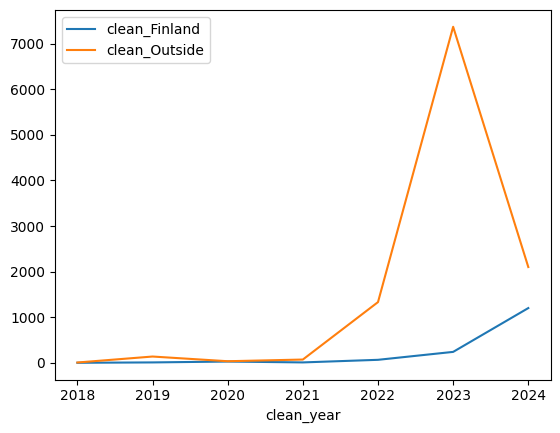

In [37]:
(fi_data
 .assign(
     clean_year=fi_data.Year.str.split(' ',expand=True)[0],
     clean_Finland=fi_data.Finland.str.replace('Around ','').astype('int32'),
     clean_Outside=fi_data['Finnish operators’ notifications outside of Finland'].str.replace('Around ','').astype('int32')
 )
 .set_index('clean_year')
 .plot()
)